In [1]:
from pyspark.sql.types import *
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, min, max
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.corpus import stopwords
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("whitegrid")


PATH = r"C:\Users\cuong\2021 Machine Learning\data"
conf = SparkConf().setAppName("CIS5367 Midterm App").setMaster("local")
sc = SparkContext(conf=conf)
spark = SparkSession(sc)
sql_context = SQLContext(sc)

In [2]:
def get_data():
    twitter_data = sql_context.read.load("%s/Womens Clothing E-Commerce Reviews.csv" % PATH,    
                      format='com.databricks.spark.csv', 
                      header='true', 
                      inferSchema='true')
    #Delete all duplicated rows
    #twitter_data = twitter_data.distinct()
    
    #Return a dataframe
    return twitter_data


In [3]:
########################### Getting the Dataset
twitter_data = get_data().dropna()
#twitter_data.show()
twitter_data.count()

17893

In [4]:
from pyspark.ml.feature import StringIndexer
rating_indexer = StringIndexer(inputCol="Rating", outputCol="rating_index")
df_rating_indexed = rating_indexer.fit(twitter_data).transform(twitter_data)
#df_rating_indexed.show()

In [5]:
from pyspark.ml.feature import StringIndexer
rating_indexer = StringIndexer(inputCol="Rating", outputCol="rating_index")
df_rating_indexed = rating_indexer.fit(twitter_data).transform(twitter_data)
#df_rating_indexed.show()
df_tweets = df_rating_indexed.where("rating_index < 5")
#df_tweets.show()
df_tweets.count()


15660

In [6]:
import pandas as pd
import re
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from nltk.stem.snowball import SnowballStemmer
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.sql.functions import udf, lit
from pyspark.sql.types import StringType, ArrayType

In [7]:
df_train_raw, df_test_raw = df_tweets.randomSplit([0.8, 0.2])
#df_train_raw.show()

print ("\nTest Count::::: " , df_test_raw.count())
print ("\nTrain Count::::: " , df_train_raw.count())


df_train_raw = df_train_raw.withColumn("part", lit(1))
df_test_raw = df_test_raw.withColumn("part", lit(0))
df_all_raw = df_train_raw.union(df_test_raw)
#df_all_raw.show()


Test Count:::::  3114

Train Count:::::  12546


In [8]:
############################## Preprocess Data

#Preprocessing Data
tokenizer = Tokenizer(inputCol='Review Text', outputCol='words')
wordsData = tokenizer.transform(df_all_raw). \
    select('rating_index', 'words', 'part')
    
# Remove number
filter = re.compile(r"^[a-zA-Z]+$")
match_udf = udf(lambda tokens: [token for token in tokens if filter.match(token)], ArrayType(StringType()))
df_matched = wordsData.withColumn("words_matched", match_udf("words")). \
    select('words_matched', 'rating_index','words','part')
    
# Remove stop words
remover = StopWordsRemover(inputCol='words_matched', outputCol='words_clean')
df_words_clean = remover.transform(df_matched). \
    select('words_clean', 'rating_index', 'part','words')

# Stem text
stemmer = SnowballStemmer(language='english')
stemmer_udf = udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))
df_stemmed = df_words_clean.withColumn("words_stemmed", stemmer_udf("words_clean")). \
    select('words_stemmed', 'rating_index', 'part')
    
print(df_stemmed)

DataFrame[words_stemmed: array<string>, rating_index: double, part: int]


In [9]:
df_stemmed.count()

15660

In [10]:
from pyspark.ml.feature import StringIndexer
# tf-idf
hashingTF = HashingTF(inputCol="words_stemmed", outputCol="rawFeatures") #generate vectors
featurizedData = hashingTF.transform(df_stemmed)
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

In [11]:
df_train = rescaledData.where("part = 1")
df_test = rescaledData.where("part = 0")
#df_test.show()

In [12]:
# Naive Bayes classifier- first model
from pyspark.ml.classification import NaiveBayes
   
nb = NaiveBayes(labelCol="rating_index",\
    featuresCol="features", smoothing=1.0,\
    modelType="multinomial")
model = nb.fit(df_train)

In [13]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
predictions = model.transform(df_test)
predictions.select("rating_index", 
                   "probability", "prediction").show()
evaluator =\
    MulticlassClassificationEvaluator(labelCol="rating_index",\
    predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = " + str(accuracy))

+------------+--------------------+----------+
|rating_index|         probability|prediction|
+------------+--------------------+----------+
|         2.0|[4.05078109570589...|       1.0|
|         2.0|[0.99938170773280...|       0.0|
|         0.0|[0.99999999999983...|       0.0|
|         0.0|[1.0,6.2838364754...|       0.0|
|         0.0|[0.99999736550671...|       0.0|
|         1.0|[0.98497652815615...|       0.0|
|         0.0|[0.99997780260379...|       0.0|
|         2.0|[0.99999999999988...|       0.0|
|         3.0|[0.99999999999845...|       0.0|
|         0.0|[0.99943292550508...|       0.0|
|         0.0|[1.0,6.6561144292...|       0.0|
|         3.0|[0.04016450334031...|       2.0|
|         3.0|[0.99999870213410...|       0.0|
|         0.0|[1.0,4.0082088646...|       0.0|
|         4.0|[1.0,5.6100451529...|       0.0|
|         0.0|[0.99999999997291...|       0.0|
|         0.0|[0.99999999982443...|       0.0|
|         0.0|[0.99986336816374...|       0.0|
|         3.0

In [14]:
def get_testdata():
    twitter_testdata = sql_context.read.load("%s/twitter__finaldata.csv" % PATH,    
                      format='com.databricks.spark.csv', 
                      header='true', 
                      inferSchema='true')
    #Delete all duplicated rows
    #twitter_data = twitter_data.distinct()
    
    #Return a dataframe
    return twitter_testdata

In [15]:
twitter_fashion_data = get_testdata()

In [16]:
twitter_fashion_data.show()

+--------------+-------------------+--------------------+----------+
|      username|             userid|               tweet|brand_name|
+--------------+-------------------+--------------------+----------+
|     hudaxbkpp|1021090604753666050|RT bkppstyle HBD2...|     Gucci|
|   DaveStangis|           18977445|Why Patagonia Guc...|     Gucci|
|     nattwd___|          385279205|RT bkppstyle HBD2...|     Gucci|
|     kkkk_k810|1157144219590381568|RT bkppstyle HBD2...|     Gucci|
|   NelsonJr323|          775352042|phatfarm n gucci ...|     Gucci|
|       k_sujar|         2757440294|RT bkppstyle HBD2...|     Gucci|
|      dojaskai|1264520169847750656|RT KaiHypeStation...|     Gucci|
|       LL01151|1327541483176509440|RT bkppstyle HBD2...|     Gucci|
|  TeamKaiPromo|1361461916552597504|RT KaiHypeStation...|     Gucci|
|   pawndetroit|           98627256|Shop our extensiv...|     Gucci|
|  Hardcorepawn|           98628224|Luxury for all Sh...|     Gucci|
|      sxrannn_|         331449126

In [17]:
#Preprocessing Data
tokenizer = Tokenizer(inputCol='tweet', outputCol='words')
wordsData = tokenizer.transform(twitter_fashion_data). \
    select('userid', 'brand_name','words')
    
# Remove number
filter = re.compile(r"^[a-zA-Z]+$")
match_udf = udf(lambda tokens: [token for token in tokens if filter.match(token)], ArrayType(StringType()))
df_matched = wordsData.withColumn("words_matched", match_udf("words")). \
    select('words_matched','words', 'userid', 'brand_name')
    
# Remove stop words
remover = StopWordsRemover(inputCol='words_matched', outputCol='words_clean')
df_words_clean = remover.transform(df_matched). \
    select('words_clean','words','userid', 'brand_name')

# Stem text
stemmer = SnowballStemmer(language='english')
stemmer_udf = udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))
df_stemmed = df_words_clean.withColumn("words_stemmed", stemmer_udf("words_clean")). \
    select('words_stemmed', 'userid', 'brand_name')
    
df_stemmed.show(2)

# tf-idf
hashingTF = HashingTF(inputCol="words_stemmed", outputCol="rawFeatures") #generate vectors
featurizedData = hashingTF.transform(df_stemmed)
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
fashion_df_rescaled = idfModel.transform(featurizedData)
#fashion_df_rescaled.show()

+--------------------+-------------------+----------+
|       words_stemmed|             userid|brand_name|
+--------------------+-------------------+----------+
|[rt, bkppstyle, g...|1021090604753666050|     Gucci|
|[patagonia, gucci...|           18977445|     Gucci|
+--------------------+-------------------+----------+
only showing top 2 rows



In [18]:
########## Perform Sentiment Analysis

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
predictions = model.transform(fashion_df_rescaled)
predictions.select("userid","brand_name","probability", "prediction").show()

+-------------------+----------+--------------------+----------+
|             userid|brand_name|         probability|prediction|
+-------------------+----------+--------------------+----------+
|1021090604753666050|     Gucci|[2.55656046102430...|       3.0|
|           18977445|     Gucci|[1.56080799147793...|       1.0|
|          385279205|     Gucci|[2.55656046102430...|       3.0|
|1157144219590381568|     Gucci|[2.55656046102430...|       3.0|
|          775352042|     Gucci|[0.46050378179478...|       1.0|
|         2757440294|     Gucci|[2.55656046102430...|       3.0|
|1264520169847750656|     Gucci|[0.99972680970976...|       0.0|
|1327541483176509440|     Gucci|[2.55656046102430...|       3.0|
|1361461916552597504|     Gucci|[0.99972680970976...|       0.0|
|           98627256|     Gucci|[0.10070030898824...|       1.0|
|           98628224|     Gucci|[0.99921870007367...|       0.0|
|         3314491261|     Gucci|[2.55656046102430...|       3.0|
|          406070295|    

In [19]:
def plot_prediction(brand_name):
    import pandas as pd
    subdf = predictions.where(predictions.brand_name == brand_name)
    subdf.select(avg("prediction")).show()
    #subdf.show()
    print("Number of rows are: " + str(subdf.count()))
    
    bins, counts = subdf.select('prediction').rdd.flatMap(lambda x: x).histogram(6)
    plt.title("Twitter Sentiment Analysis:" + brand_name)
    plt.xlabel("Sentiment Prediction")
    plt.ylabel("# of Tweets")
    plt.hist(bins[:-1], bins=bins, weights=counts)
    plt.show()

+------------------+
|   avg(prediction)|
+------------------+
|0.8906666666666667|
+------------------+

Number of rows are: 1500


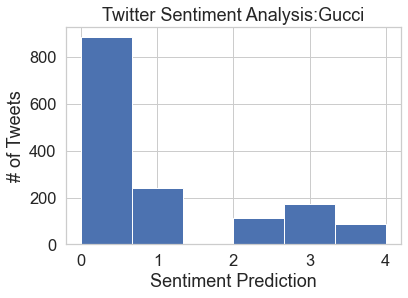

+------------------+
|   avg(prediction)|
+------------------+
|1.1673333333333333|
+------------------+

Number of rows are: 1500


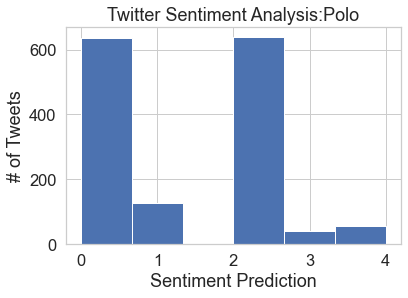

+---------------+
|avg(prediction)|
+---------------+
|          0.814|
+---------------+

Number of rows are: 1500


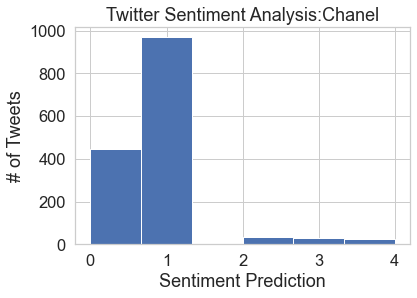

+------------------+
|   avg(prediction)|
+------------------+
|0.9446666666666667|
+------------------+

Number of rows are: 1500


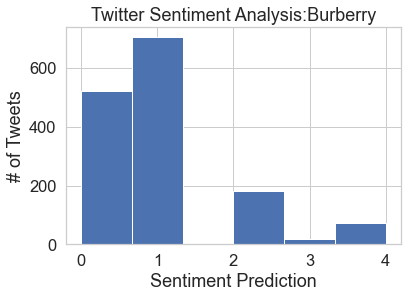

+------------------+
|   avg(prediction)|
+------------------+
|1.0356012658227849|
+------------------+

Number of rows are: 1264


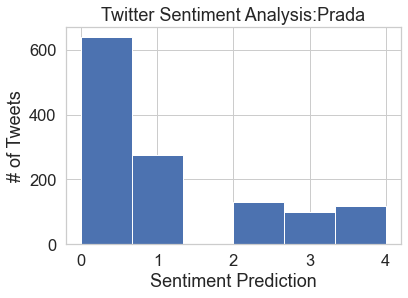

+------------------+
|   avg(prediction)|
+------------------+
|1.0262390670553936|
+------------------+

Number of rows are: 343


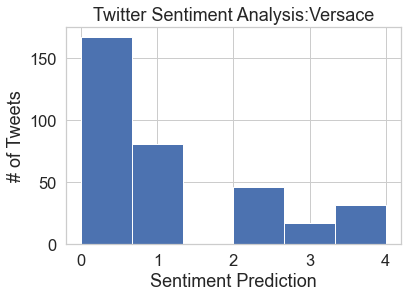

+---------------+
|avg(prediction)|
+---------------+
|          1.054|
+---------------+

Number of rows are: 1500


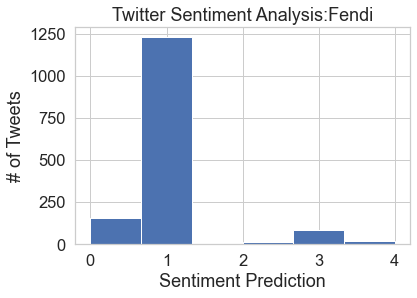

+------------------+
|   avg(prediction)|
+------------------+
|1.1775700934579438|
+------------------+

Number of rows are: 535


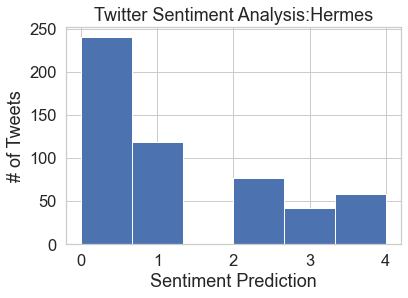

In [20]:
keyword_list = ('Gucci','Polo','Chanel','Burberry','Prada','Versace','Fendi','Hermes')
for brand_name in keyword_list:
    plot_prediction(brand_name)

In [112]:
sc.stop()